In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import os

In [3]:
train_path='/home/deepaksr/project/project_assignment1/data3/SeekThermal/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data3/SeekThermal/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: Man
Images: 1782

class: Cat
Images: 1168

class: Car
Images: 1782

Test Data:
class: car
Images: 356

class: cat
Images: 356

class: man
Images: 356



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [4]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

2024-09-04 21:42:04.673793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 21:42:04.696252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 21:42:04.702794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 21:42:04.719232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 21:42:05.667605: W tensorflow/comp

In [5]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.2)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 3787 images belonging to 3 classes.
Found 945 images belonging to 3 classes.


Found 1068 images belonging to 3 classes.
{'Car': 0, 'Cat': 1, 'Man': 2}
3787
{'Car': 0, 'Cat': 1, 'Man': 2}
945
{'car': 0, 'cat': 1, 'man': 2}
1068


Checking Shape of loaded data batches

In [6]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (32, 300, 300, 3), Labels shape: (32, 3)
Validation batch shape: (32, 300, 300, 3), Labels shape: (32, 3)
Test batch shape: (32, 300, 300, 3), Labels shape: (32, 3)


Define the CNN using MobileNet Backbone

In [6]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load MobileNet pretrained model
    conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_mobilenet((300,300,3), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


2024-09-04 21:42:15.283314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
/tmp/ipykernel_2970856/1533827763.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 150, 150, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 150, 150, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 151, 151, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 75, 75, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 75, 75, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 75, 75, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 75, 75, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 45,698,243 (174.32 MB)

 Trainable params: 44,064,259 (168.09 MB)

 Non-trainable params: 1,633,984 (6.23 MB)

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725466350.498478 2972475 service.cc:146] XLA service 0x7fb9f802c140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725466350.498589 2972475 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-09-04 21:42:30.662078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 21:42:31.395141: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

  2/119 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.2891 - loss: 4.5473  

I0000 00:00:1725466358.094029 2972475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 56/119 ━━━━━━━━━━━━━━━━━━━━ 52s 841ms/step - accuracy: 0.7735 - loss: 14.7899

E0000 00:00:1725466406.809932 2972480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725466406.936544 2972480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.8464 - loss: 9.8507

E0000 00:00:1725466478.935163 2972477 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725466479.071054 2972477 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8478 - loss: 9.7540 - val_accuracy: 0.7418 - val_loss: 10.1215
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 119s 950ms/step - accuracy: 0.9870 - loss: 0.2167 - val_accuracy: 0.7587 - val_loss: 9.0924
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 122s 973ms/step - accuracy: 0.9903 - loss: 0.1805 - val_accuracy: 0.6910 - val_loss: 25.7329
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 120s 959ms/step - accuracy: 0.9923 - loss: 0.0755 - val_accuracy: 0.7270 - val_loss: 16.7377
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 122s 974ms/step - accuracy: 0.9910 - loss: 0.1284 - val_accuracy: 0.7587 - val_loss: 14.6176
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 122s 972ms/step - accuracy: 0.9912 - loss: 0.0938 - val_accuracy: 0.7397 - val_loss: 29.6527
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 120s 956ms/step - accuracy: 0.9942 - loss: 0.0559 - val_accuracy: 0.7577 - val_loss: 18.8674
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 121s 963ms/step - accuracy: 0.9840 - loss: 0

In [8]:
history_dict = history.history

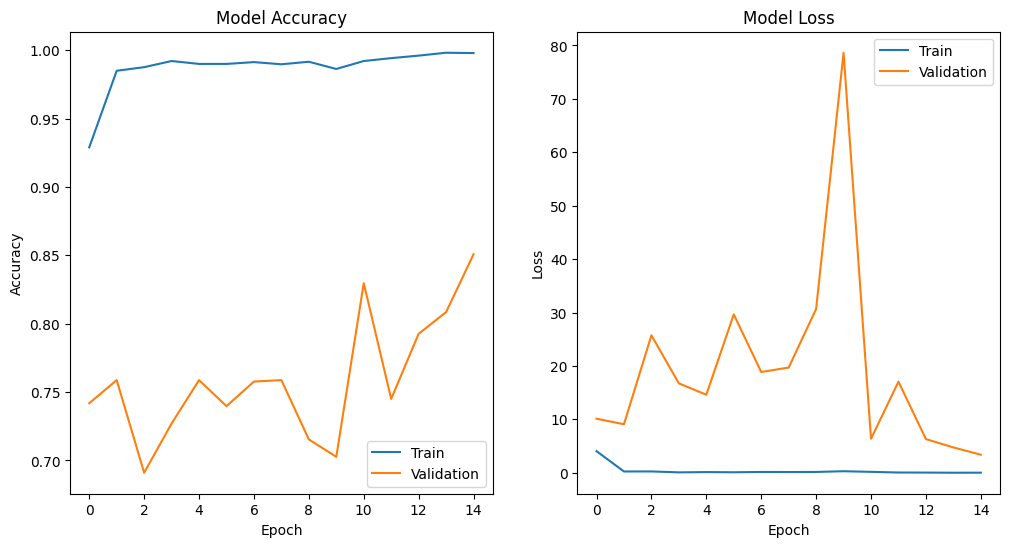

In [9]:
import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [10]:
import numpy as np # type: ignore
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step

E0000 00:00:1725468227.332414 2972475 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725468227.462531 2972475 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 942ms/step
[0 0 0 ... 2 2 2]


array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [11]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report # type: ignore
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9616
Precision : 0.9615
Recall : 0.9616
F1 Score : 0.9615
Classification Report:
               precision    recall  f1-score   support

         car       0.98      0.99      0.98       356
         cat       0.95      0.93      0.94       356
         man       0.95      0.96      0.96       356

    accuracy                           0.96      1068
   macro avg       0.96      0.96      0.96      1068
weighted avg       0.96      0.96      0.96      1068



In [12]:
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[352   3   1]
 [  8 332  16]
 [  0  13 343]]


Define the CNN using VGG16 Backbone

In [13]:
from keras.applications.vgg16 import VGG16, preprocess_input # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_VGG(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load VGG16 pretrained model
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_VGG((300,300,3), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=15)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,950,403 (137.14 MB)

 Trainable params: 35,911,683 (136.99 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [14]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


2024-09-04 22:14:33.160520: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:14:34.258385: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:14:36.214577: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:14:37.460609: W external/local_tsl/tsl/framework/bfc

 54/119 ━━━━━━━━━━━━━━━━━━━━ 56s 863ms/step - accuracy: 0.4967 - loss: 1.1352

2024-09-04 22:15:34.409535: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:15:34.895499: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:15:35.634216: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 22:15:36.399993: W external/local_tsl/tsl/framework/bfc_

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6198 - loss: 0.8725

2024-09-04 22:16:34.901997: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1725468418.723589 2972480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725468418.886164 2972480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


119/119 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.6211 - loss: 0.8696 - val_accuracy: 0.7651 - val_loss: 0.6750
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 122s 974ms/step - accuracy: 0.9308 - loss: 0.1821 - val_accuracy: 0.7608 - val_loss: 0.8545
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 117s 929ms/step - accuracy: 0.9572 - loss: 0.1336 - val_accuracy: 0.7249 - val_loss: 1.5514
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 118s 944ms/step - accuracy: 0.9623 - loss: 0.1046 - val_accuracy: 0.7450 - val_loss: 1.9991
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 118s 941ms/step - accuracy: 0.9772 - loss: 0.0691 - val_accuracy: 0.7397 - val_loss: 1.6749
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 118s 944ms/step - accuracy: 0.9833 - loss: 0.0493 - val_accuracy: 0.7820 - val_loss: 1.1245
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 117s 935ms/step - accuracy: 0.9850 - loss: 0.0390 - val_accuracy: 0.7439 - val_loss: 2.3697
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 116s 928ms/step - accuracy: 0.9719 - loss: 0.0771 

In [15]:
history_dict = history.history

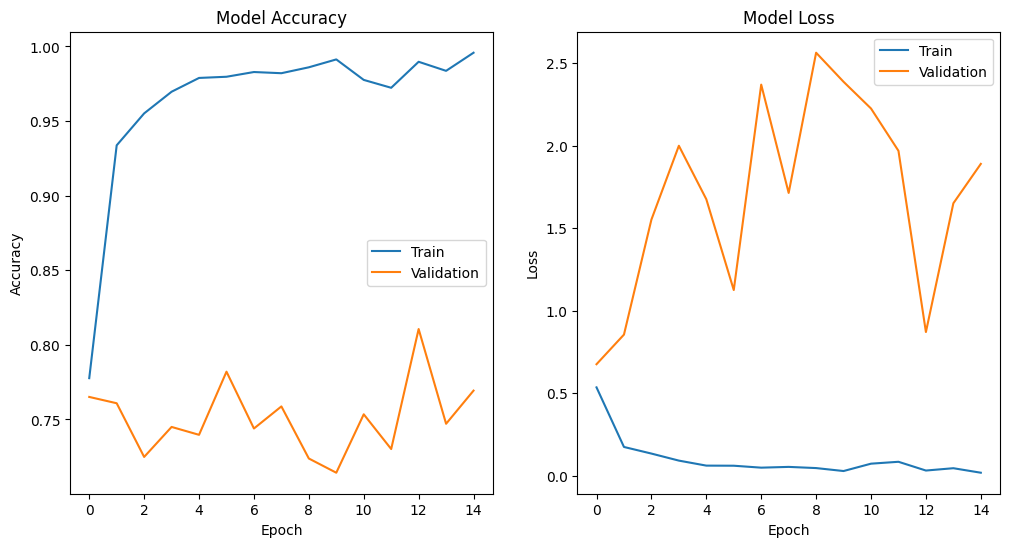

In [16]:
import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [17]:
import numpy as np # type: ignore
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step

E0000 00:00:1725470213.230226 2972479 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725470213.388677 2972479 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 959ms/step
[0 0 0 ... 0 2 2]


array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [18]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report # type: ignore
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9522
Precision : 0.9572
Recall : 0.9522
F1 Score : 0.9522
Classification Report:
               precision    recall  f1-score   support

         car       0.99      0.99      0.99       356
         cat       1.00      0.87      0.93       356
         man       0.88      0.99      0.93       356

    accuracy                           0.95      1068
   macro avg       0.96      0.95      0.95      1068
weighted avg       0.96      0.95      0.95      1068



In [19]:
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[354   0   2]
 [  0 310  46]
 [  2   1 353]]


Classification using Pre-Trained RESNET 50

In [20]:
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_resnet_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load ResNet50 pretrained model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze base model layers
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    # Adding custom layers on top
    x = base_model.output
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)  
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_resnet_model((300, 300, 3), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 128,447,363 (489.99 MB)

 Trainable params: 110,380,035 (421.07 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [21]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5039 - loss: 12.1689 - val_accuracy: 0.3799 - val_loss: 3.5460
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 115s 916ms/step - accuracy: 0.7898 - loss: 0.5261 - val_accuracy: 0.3799 - val_loss: 2.7474
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 114s 910ms/step - accuracy: 0.8395 - loss: 0.4472 - val_accuracy: 0.5577 - val_loss: 1.1915
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 114s 915ms/step - accuracy: 0.8461 - loss: 0.3953 - val_accuracy: 0.4042 - val_loss: 3.1429
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 114s 910ms/step - accuracy: 0.8632 - loss: 0.3592 - val_accuracy: 0.4931 - val_loss: 2.4165
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 114s 913ms/step - accuracy: 0.8444 - loss: 0.4152 - val_accuracy: 0.2466 - val_loss: 6.1105
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 115s 914ms/step - accuracy: 0.8895 - loss: 0.3039 - val_accuracy: 0.5005 - val_loss: 1.4896
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 115s 921ms/step - accuracy: 0.8855 - l

In [22]:
history_dict = history.history

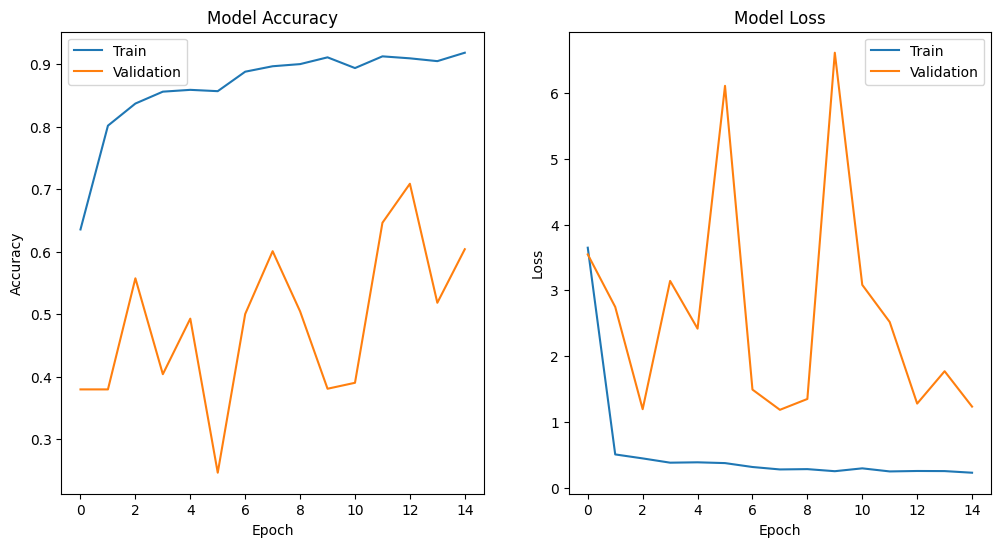

In [23]:
import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [24]:
import numpy as np # type: ignore
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 946ms/step
[0 1 1 ... 0 1 1]


array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [25]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report # type: ignore
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.7940
Precision : 0.8423
Recall : 0.7940
F1 Score : 0.7893
Classification Report:
               precision    recall  f1-score   support

         car       0.91      0.89      0.90       356
         cat       0.65      0.95      0.77       356
         man       0.97      0.54      0.70       356

    accuracy                           0.79      1068
   macro avg       0.84      0.79      0.79      1068
weighted avg       0.84      0.79      0.79      1068



In [26]:
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[317  38   1]
 [ 13 337   6]
 [ 17 145 194]]
